
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [4]:
## library imports here
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [7]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.info()

cat = ['sex', 'restecg', 'output']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [17]:
X = ha.drop("cp", axis=1)
y = ha["cp"]

X[cat] = X[cat].astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline([
                ("scaler", StandardScaler())
            ]),
            make_column_selector(dtype_include=np.number)
        ),
        (
            "cat",
            Pipeline([
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]),
            make_column_selector(dtype_include=["object", "category"])
        ),
    ]
)

knn_pipe = Pipeline([
    ("preprocess", preprocess),
    ("knn", KNeighborsClassifier())
])

knn_params = {
    "knn__n_neighbors": [3,5,7,9,11,15],
    "knn__weights": ["uniform", "distance"]
}

knn_search = GridSearchCV(knn_pipe, knn_params,cv=5, scoring="accuracy"
)
knn_search.fit(X_train, y_train)

print("Best KNN params:", knn_search.best_params_)
print("Best CV accuracy:", knn_search.best_score_)


tree_pipe = Pipeline([
    ("preprocess", preprocess),
    ("tree", DecisionTreeClassifier(random_state=42))
])

tree_params = {
    "tree__max_depth": [3,5,7,10,None],
    "tree__min_samples_split": [2,10,20,40],
    "tree__min_samples_leaf": [1,5,10,20]
}

tree_search = GridSearchCV(
    tree_pipe,
    tree_params,
    cv=5,
    scoring="accuracy"
)

tree_search.fit(X_train, y_train)

print("Best Tree params:", tree_search.best_params_)
print("Best CV accuracy:", tree_search.best_score_)


lda_pipe = Pipeline([
    ("preprocess", preprocess),
    ("lda", LinearDiscriminantAnalysis())
])

lda_pipe.fit(X_train, y_train)

lda_pipe.score(X_test, y_test)




Best KNN params: {'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
Best CV accuracy: 0.5826638477801268
Best Tree params: {'tree__max_depth': 7, 'tree__min_samples_leaf': 10, 'tree__min_samples_split': 2}
Best CV accuracy: 0.5456659619450317
[-0.95416576 -2.65346318 -1.49527901 -3.00085776]


array([[ 0.00675074, -0.17771549,  0.07001685, -0.40691431,  0.1820698 ,
        -0.1820698 ,  0.08214739, -0.07068244, -0.21234103,  0.83189543,
        -0.83189543],
       [-0.10767251,  0.1037138 ,  0.02117453,  0.59497155, -0.44322482,
         0.44322482, -0.25701343,  0.25588912,  0.04213904, -0.99324109,
         0.99324109],
       [-0.01309587,  0.0840969 , -0.06885353,  0.24291468,  0.0356009 ,
        -0.0356009 , -0.01163085, -0.01358664,  0.45257594, -0.71129521,
         0.71129521],
       [ 0.2456996 ,  0.56441861, -0.21295925,  0.30573757, -0.33576934,
         0.33576934,  0.08577763, -0.05396116, -0.57709485, -0.24098169,
         0.24098169]])

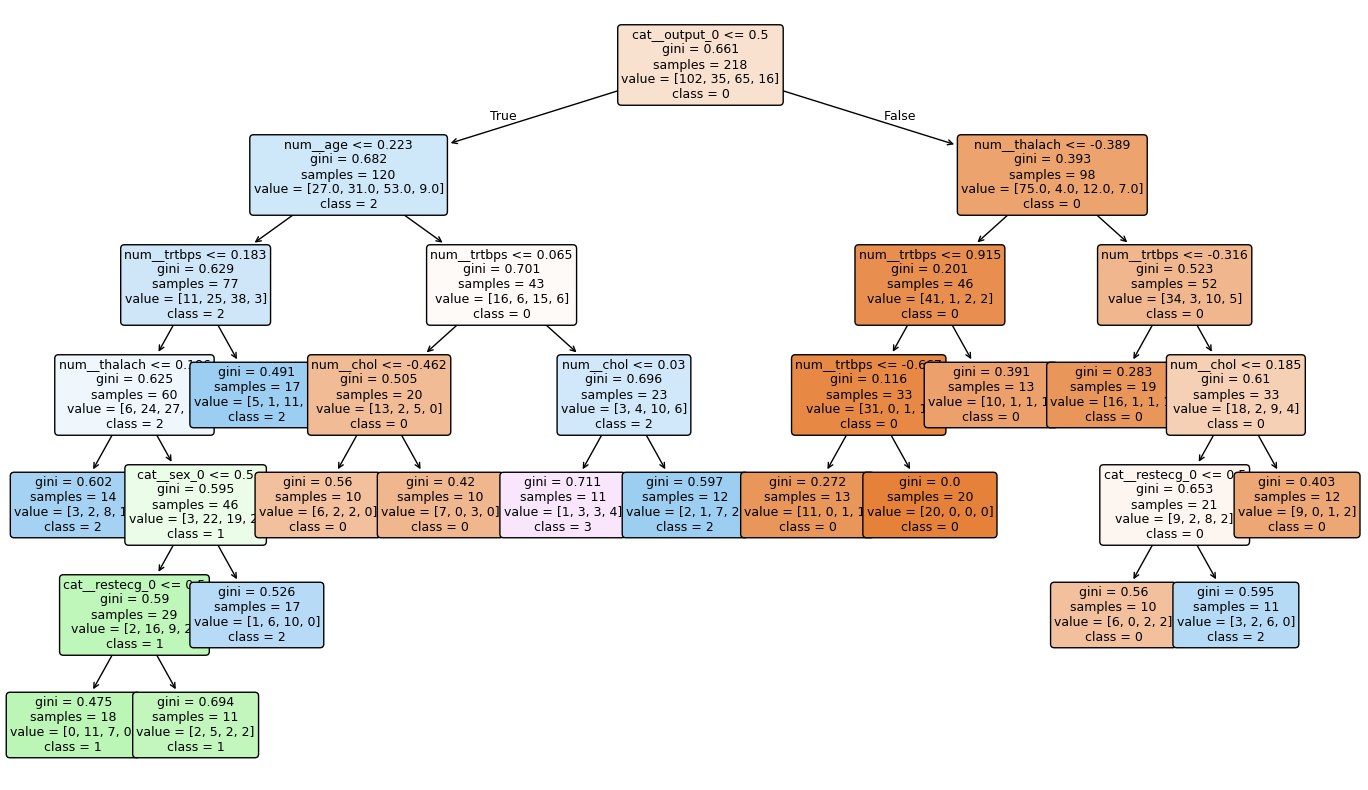

In [23]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

best_pipe = tree_search.best_estimator_
best_tree = best_pipe.named_steps["tree"]

preprocess = best_pipe.named_steps["preprocess"]
feature_names = preprocess.get_feature_names_out()

plt.figure(figsize=(14, 8))
plot_tree(
    best_tree,
    feature_names=feature_names,
    class_names=[str(c) for c in best_tree.classes_]
    if hasattr(best_tree, "classes_") else None,
    filled=True,
    rounded=True,
    fontsize=9
)
plt.tight_layout()
plt.show()

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [31]:
ha['cp_is_3'] = ha['cp'] == 3

X = ha.drop(["cp", "cp_is_3"], axis=1)
y = ha["cp_is_3"]

X[cat] = X[cat].astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

log_pipe = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=2000))
])

log_params = {
    "logreg__C": [0.001, 0.01, 0.1, 1, 10]
}

log_search = GridSearchCV(
    log_pipe,
    log_params,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

log_search.fit(X_train, y_train)

print("Best Logistic params:", log_search.best_params_)
print("Best CV for 3 f1", log_search.best_score_)

ha['cp_is_0'] = ha['cp'] == 0

X = ha.drop(["cp", "cp_is_3", 'cp_is_0'], axis=1)
y = ha["cp_is_0"]

X[cat] = X[cat].astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

log_pipe = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=2000))
])

log_params = {
    "logreg__C": [0.001, 0.01, 0.1, 1, 10]
}

log_search = GridSearchCV(
    log_pipe,
    log_params,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

log_search.fit(X_train, y_train)

print("Best Logistic params:", log_search.best_params_)
print("Best CV for 0 f1", log_search.best_score_)

ha['cp_is_1'] = ha['cp'] == 1

X = ha.drop(["cp", "cp_is_3", 'cp_is_0', 'cp_is_1'], axis=1)
y = ha["cp_is_1"]

X[cat] = X[cat].astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

log_pipe = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=2000))
])

log_params = {
    "logreg__C": [0.001, 0.01, 0.1, 1, 10]
}

log_search = GridSearchCV(
    log_pipe,
    log_params,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

log_search.fit(X_train, y_train)

print("Best Logistic params:", log_search.best_params_)
print("Best CV for 1 f1", log_search.best_score_)

ha['cp_is_2'] = ha['cp'] == 2

X = ha.drop(["cp", "cp_is_3", 'cp_is_0', 'cp_is_1', 'cp_is_2'], axis=1)
y = ha["cp_is_2"]

X[cat] = X[cat].astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

log_pipe = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=2000))
])

log_params = {
    "logreg__C": [0.001, 0.01, 0.1, 1, 10]
}

log_search = GridSearchCV(
    log_pipe,
    log_params,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

log_search.fit(X_train, y_train)

print("Best Logistic params:", log_search.best_params_)
print("Best CV for 2 f1", log_search.best_score_)

Best Logistic params: {'logreg__C': 0.001}
Best CV for 3 f1 0.0
Best Logistic params: {'logreg__C': 0.1}
Best CV for 0 f1 0.6977888519748985
Best Logistic params: {'logreg__C': 0.001}
Best CV for 1 f1 0.0
Best Logistic params: {'logreg__C': 10}
Best CV for 2 f1 0.14543417366946776


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [38]:
df = ha.drop(columns = ['cp_is_3', 'cp_is_2', 'cp_is_0', 'cp_is_1'])
df01 = df[df['cp'].isin([0, 1])].copy()

X01 = df01.drop(columns=['cp'])
y01 = df01['cp']

X_train, X_test, y_train, y_test = train_test_split(
    X01, y01, test_size=0.2, random_state=42, stratify=y01
)


log_search = GridSearchCV(
    log_pipe,
    log_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

log_search.fit(X_train, y_train)

print("Best Logistic params:", log_search.best_params_)
print("Best CV ROC AUC:", log_search.best_score_)

df02 = df[df['cp'].isin([0, 2])].copy()
X02 = df02.drop(columns=['cp'])
y02 = df02['cp']

X_train, X_test, y_train, y_test = train_test_split(
    X02, y02, test_size=0.2, random_state=42, stratify=y02
)

log_search = GridSearchCV(
    log_pipe,
    log_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

log_search.fit(X_train, y_train)

print("Best Logistic params:", log_search.best_params_)
print("Best CV ROC AUC:", log_search.best_score_)

df03 = df[df['cp'].isin([0, 3])].copy()
X03 = df03.drop(columns=['cp'])
y03 = df03['cp']

X_train, X_test, y_train, y_test = train_test_split(
    X03, y03, test_size=0.2, random_state=42, stratify=y03
)

log_search = GridSearchCV(
    log_pipe,
    log_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

log_search.fit(X_train, y_train)

print("Best Logistic params:", log_search.best_params_)
print("Best CV ROC AUC:", log_search.best_score_)

Best Logistic params: {'logreg__C': 1}
Best CV ROC AUC: 0.897891156462585
Best Logistic params: {'logreg__C': 1}
Best CV ROC AUC: 0.7433333333333333
Best Logistic params: {'logreg__C': 10}
Best CV ROC AUC: 0.7684126984126983


After reducing the dataset to the different OvO pairs and running a tuned Logistic Regression, the ROC–AUC scores were:

cp 0 vs 1: 0.8979

cp 0 vs 2: 0.7433

cp 0 vs 3: 0.7684

Since the highest ROC–AUC is for cp 0 vs 1, the OvO approach has chest pain types 0 and 1 the best.